In [1]:
# imports
import torch
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import json
import random
import os
from PIL import Image
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# path to folders with images
data_dir = 'flower_data'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'

In [3]:
batch_size = 24
valid_size = 0.2 # percentage of train dataset to use for validation

# transforms
train_transform = transforms.Compose([transforms.RandomRotation(30), 
                                      transforms.RandomResizedCrop(224),
                                      transforms.RandomHorizontalFlip(p=0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                     ])

test_transform = transforms.Compose([transforms.Resize(255),
                                     transforms.CenterCrop(224), 
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                                    ])

# define train and test datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(valid_dir, transform=test_transform)

# split train dataset into train and validation set
num_train = len(train_dataset)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# load datasets
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [4]:
vgg16 = models.vgg16(pretrained=True)
vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [5]:
# change the classifier part of the pretrained model, so that the output is of size 102 instead of 1000
for param in vgg16.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(25088, 4096), 
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(512, 102),                           
                           nn.LogSoftmax(dim=1))

vgg16.classifier = classifier

criterion = nn.NLLLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr=0.0003)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1) # decreases learning rate by 90% every 6 epochs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [ ]:
# I ran this cell in the cloud and saved the model as vgg16-v2.pth

epochs = 30

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, epochs+1):
    
    train_loss = 0.0
    valid_loss = 0.0
    accuracy = 0.0
    scheduler.step()
    
    ###################
    # train the model #
    ###################
    vgg16.train()
    for inputs, labels in trainloader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        output = vgg16(inputs)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()*inputs.size(0) 
        
    ######################    
    # validate the model #
    ######################
    vgg16.eval()
    for inputs, labels in validloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        output = vgg16(inputs)
        loss = criterion(output, labels)
        valid_loss += loss.item()*inputs.size(0)
        
        # Convert back to softmax distribution
        ps = torch.exp(output)
        # Compare highest prob predicted class ps.max(dim=1)[1] with labels
        equality = (labels.data == ps.max(dim=1)[1])
        # Convert to cpu and type FloatTensor for mean
        equality.cpu()
        accuracy += equality.type(torch.FloatTensor).mean()
        
    # calculate average losses
    train_loss = train_loss/len(trainloader.dataset)
    valid_loss = valid_loss/len(validloader.dataset)
    valid_accuracy = accuracy/len(validloader)
    
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tValidation Accuracy: {:.3f}'.format(
        epoch, train_loss, valid_loss, valid_accuracy))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(vgg16.state_dict(), 'vgg16-v2.pth')
        valid_loss_min = valid_loss

Load the model back to the workbook:

In [6]:
# import vgg16 again from torch
model = models.vgg16(pretrained=False)

# update the parameters so they match the checkpoint version.
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(nn.Linear(25088, 4096), 
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(4096, 512),
                           nn.ReLU(),
                           nn.Dropout(p=0.1),
                           nn.Linear(512, 102),                           
                           nn.LogSoftmax(dim=1))

model.classifier = classifier

# load model
state_dict = torch.load('vgg16-v2.pth', map_location=device)
model.load_state_dict(state_dict)
model.eval();

In [7]:
def test(model, testloader):
    ''' Tests the model with new images'''
    
    test_loss = 0
    accuracy = 0
    
    model.to(device)
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        test_loss += criterion(output, labels)
        
        # Convert back to softmax distribution
        ps = torch.exp(output)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # Convert to cpu and type FloatTensor for mean
        equals.cpu()
        accuracy += equals.type(torch.FloatTensor).mean()
    
    return test_loss, accuracy

In [8]:
with torch.no_grad():
    model.eval()
    test_loss, accuracy = test(model, testloader)

print("Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Test Accuracy: 0.936


In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    width, height = image.size
    
    if width < height:
        divisor = width / 256
        size = (256, int(height / divisor))
    else: 
        divisor = height / 256
        size = (width / divisor, 256)        
      
    image.thumbnail(size)
    
    # center crop
    left = round((size[0] - 224))/2
    top = round((size[1] - 224))/2
    right = round((size[0] + 224))/2
    bottom = round((size[1] + 224))/2
    crop_im = image.crop((left, top, right, bottom))
    
    np_im = np.array(crop_im)
    np_im = np_im / 255
    
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalized_im = (np_im - mean) / std
    
    final_im = normalized_im.transpose(2, 0, 1)
    
    return final_im

In [11]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

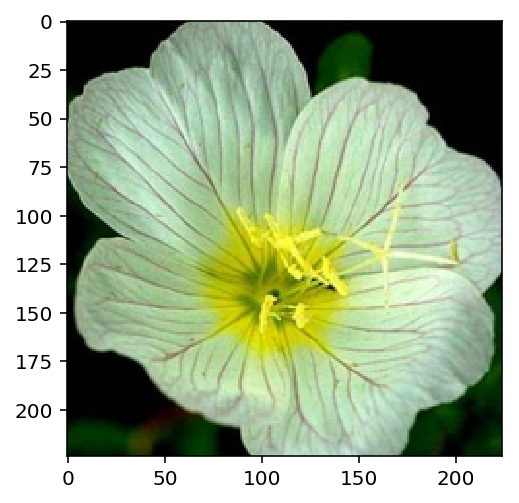

In [12]:
test_im = Image.open('flower_data/valid/1/image_06739.jpg')
im_array = process_image(test_im)
imshow(im_array);